In [3]:
# packages
import numpy as np
import pandas as pd
import random
import os

# database
import yfinance as yf
from sqlalchemy import create_engine, inspect

# quadratic
import quadprog
from scipy.optimize import minimize

# visualisation
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tabulate import tabulate


# maybe
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

/Users/jackstevenson/CQF/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Code

#### Data & Pre-Processing

In [4]:
# create our engine
engine = create_engine("sqlite:///project_portfolio.db")

df = pd.read_sql('portfolio_data', con=engine)

# # set date as index
df.set_index('Date', inplace=True)

# create separate t bill dataframe
three_month_tbill = df['3M TB'] / 252

# create separate benchmark dataframe
benchmark_spx_500 = df['Benchmark - S&P 500'].pct_change()

# consistent ordering
df = df[['Energy', 'Materials', 'Industrials', 'Consumer Discretionary', 'Consumer Staples', 'Health Care', 'Financials', 'Information Technology', 
         'Communication Services', 'Utilities', 'Real Estate', 'Volatility (Exo)', 'Commodities (Exo)', 'Bonds (Exo)', 'Factor SMB', 'Factor HML', 
         'Factor RMW', 'Factor CMA']]

# calculate simple returns
simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()

simple_returns = pd.concat([simple_returns, df[['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']]], axis=1)

/var/folders/3z/lz8knlfn5ys693qpn6bnjb440000gn/T/ipykernel_74900/3435988170.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()


#### Custom Factor - Momentum Factor

In [5]:
# lookback period 252 (approximate 12 months)
lookback_period = 252

# exclude the exogenous and fama-french
sector_momentum = simple_returns.drop(columns=['Volatility (Exo)', 'Commodities (Exo)', 
                                               'Bonds (Exo)','Factor SMB', 'Factor HML', 
                                               'Factor RMW', 'Factor CMA']).rolling(window=lookback_period).apply(lambda x: (x + 1).prod() - 1)

# rank the sector returns over lookback plus lag to prevent perfect portfolio
momentum_ranks = sector_momentum.rank(axis=1, method='first', ascending=False).shift(1).dropna()

# identify top and bottom
top_momentum_sectors = momentum_ranks <= 3  # Top 3 sectors
bottom_momentum_sectors = momentum_ranks >= 9  # Bottom 3 sectors

# construct portfolio returns from top & bottom
momentum_high_portfolio = simple_returns[top_momentum_sectors].mean(axis=1)
momentum_low_portfolio = simple_returns[bottom_momentum_sectors].mean(axis=1)

# calculate momentum factor returns
momentum_factor_return = momentum_high_portfolio - momentum_low_portfolio
momentum_factor_return_df = momentum_factor_return.to_frame(name='Factor MOM')

# add into simple_returns_df
simple_returns = pd.concat([simple_returns, momentum_factor_return_df], axis=1)

# drop the first 12 months due to lookback
simple_returns.dropna(inplace=True)

In [6]:
# subtract the 3m t bill daily rate
excess_returns = simple_returns.sub(three_month_tbill, axis=0)

# calculate log returns returns
log_returns = np.log(1 + simple_returns).dropna()

In [7]:
# common date index
common_index = log_returns.index.intersection(benchmark_spx_500.index)

# split the index between backtesting and post optimisation periods
backtesting_index = common_index[common_index < '2022-01-01']
post_optimisation_index = common_index[common_index >= '2022-01-01']

# filter for index
log_returns_back_testing = log_returns.loc[backtesting_index]
benchmark_spx_500_back_testing = benchmark_spx_500.loc[backtesting_index]

#### Black-Litterman Class Model

In [8]:
class BlackLittermanModel:
    def __init__(self, equilibrium_weights, log_returns, risk_aversion, views_mapping_matrix, views_matrix, tracking_error_target=0.0001, tau=0.025):
        self._equilibrium_weights = equilibrium_weights
        self._log_returns = log_returns
        self._risk_aversion = risk_aversion
        self._tau = tau
        self._covariance_matrix = self._calculate_covariance_matrix()
        self._views_mapping_matrix = views_mapping_matrix
        self._views_matrix = views_matrix
        self._tracking_error_target = tracking_error_target 

    # TODO: private methods
    def _calculate_covariance_matrix(self):
        # calculate the vols
        volatilities_array = self._log_returns.std()

        # calculate correlation
        correlation_coefficients = self._log_returns.corr()

        # create the diagonal vol matrix (vol on the diagonal, zeros elsewhere)
        std_diag_vol_matrix  = np.diag(volatilities_array)

        # compute the covariance matrix
        covariance_matrix = std_diag_vol_matrix @ correlation_coefficients.values @ std_diag_vol_matrix

        # pass the headers from log return 

        covariance_matrix = pd.DataFrame(
            covariance_matrix,
            columns = self._log_returns.columns,
            index = self._log_returns.columns,
        )

        return covariance_matrix
    
    def calculate_views_adjusted_returns(self):
        # we need implied equity returns and omega
        implied_returns_vector = self.calculate_implied_equilibrium_returns().values

        omega = self.calculate_uncertainty_views_matrix()

        # we have three terms for the np.dot product
        tau_sigma_transpose_p = self._tau * (self._covariance_matrix.values @ self._views_mapping_matrix.T)

        inverse_middle_term = np.linalg.inv((self._views_mapping_matrix @ tau_sigma_transpose_p) + omega)

        view_minus_p = (self._views_matrix - (self._views_mapping_matrix @ implied_returns_vector))

        views_adjusted_returns_vector = implied_returns_vector + ((tau_sigma_transpose_p @ inverse_middle_term) @ view_minus_p)

        # convert to dataframe for consistency
        views_adjusted_returns = pd.DataFrame(views_adjusted_returns_vector, columns=["Adjusted Return"], index=self._log_returns.columns)

        return views_adjusted_returns
    
    # calculate the covariance of the error terms aka omega
    def calculate_uncertainty_views_matrix(self):
        # you extract the diagonal and then convert to a diagonal matrix with zeros
        omega = np.diag(((self._views_mapping_matrix @ (self._tau * self._covariance_matrix)) @ self._views_mapping_matrix.T))
        
        return np.diag(omega)

    
    def calculate_implied_equilibrium_returns(self):
        implied_returns_vector = self._risk_aversion * (self._covariance_matrix @ self._equilibrium_weights)

        implied_returns = pd.DataFrame(implied_returns_vector, columns=["Implied Return"], index=self._log_returns.columns)

        return implied_returns
    
    def calculate_unconstrained_mv_optimisation(self):
        # invert the covariance matrix
        inv_cov_matrix = np.linalg.inv(self._covariance_matrix)

        # calculate adjusted returns
        adjusted_returns = self.calculate_views_adjusted_returns().values

        # obtain weights
        optimal_weights = self._risk_aversion * np.dot(inv_cov_matrix, adjusted_returns)

        # # normalise the sum of weights to 1
        optimal_weights /= np.sum(optimal_weights)

        # convert to dataframe for consistency
        optimal_weights = pd.DataFrame(optimal_weights, columns=["Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    def generate_mv_constraint_matrices(self, implied_returns_vector_values):
        # we will generate our two constraints - no short selling & no leverage
        number_of_assets = len(implied_returns_vector_values)

        # no short selling
        no_short_selling_constraint_coefficient = np.eye(number_of_assets)
        no_short_selling_constraint_rhs = np.zeros(number_of_assets)

        # no leverage - you need to transpose the 
        no_leverage_constraint_coefficient = np.ones([1, number_of_assets])
        no_leverage_constraint_rhs = np.array([1.0])

        # stack them together
        C_constraint_matrix = np.vstack([no_leverage_constraint_coefficient, no_short_selling_constraint_coefficient])
        b_constraint_matrix = np.hstack([no_leverage_constraint_rhs, no_short_selling_constraint_rhs])

        return C_constraint_matrix, b_constraint_matrix
    
        
    def calculate_constrained_mv_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        # we are solving an equation of the form - 1/2 x^T G x - a^T x s.t. C.T x >= b
        quadratic_G = self.risk_aversion * self._covariance_matrix.values

        quadratic_a = self.calculate_views_adjusted_returns().values.flatten()

        # generate constraints
        C_constraint_matrix, b_constraint_matrix = self.generate_mv_constraint_matrices(implied_returns_vector_values)

        # solve for weights
        optimal_weights = quadprog.solve_qp(quadratic_G, quadratic_a, C_constraint_matrix.T, b_constraint_matrix, meq=1)[0]

        optimal_weights = pd.DataFrame(optimal_weights, columns=["Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    
    def calculate_tracking_error_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        number_of_assets = len(implied_returns_vector_values)

        adjusted_returns = self.calculate_views_adjusted_returns().values

        # constraints
        constraints = [{'type': 'eq', 'fun': self.zero_sum_equality_constraint},
                       {'type': 'eq', 'fun': self.tracking_error_target_constraint}]
        

        # bounds - no short selling or other constraints
        bounds = [(None, None)] * number_of_assets

        # initial guess - very small non-zero deviation
        x0 = np.ones(number_of_assets) * 1e-3

        # generate weights
        results = minimize(fun= self.objective_function, x0=x0, bounds=bounds, constraints=constraints)
        
        if not results.success:
            print("Optimization failed:", results.message)
            return None

        optimal_deviations = results.x

        # create a series from the deviations with the same index as the eq weights
        optimal_deviations = pd.Series(results.x, index=self._equilibrium_weights.index)

        optimal_weights = self._equilibrium_weights + optimal_deviations

        optimal_weights = pd.DataFrame(optimal_weights, columns=["TE Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    # Tracking Error - objective and constraints
    def objective_function(self, x):
        # maximise returns
        adjusted_returns = self.calculate_views_adjusted_returns().values
        value = - np.dot(x, adjusted_returns)
        # print(f"Objective function value: {value} for x: {x}")


        return value
    
    def zero_sum_equality_constraint(self, x):
        # constraint - sum of deviations is zero
        value = np.sum(x)
        # print(f"Zero sum constraint value: {value} for x: {x}")

        return value
    
    def tracking_error_target_constraint(self, x):
        value = np.dot(x.T, np.dot(self.covariance_matrix, x)) - self._tracking_error_target
        # print(f"Tracking error constraint value: {value} for x: {x}")

        return value


    # attributes
    # tau
    @property
    def tau(self):
        return self._tau

    @tau.setter
    def tau(self, value):
        self._tau = value

    # risk aversion 
    @property
    def risk_aversion(self):
        return self._risk_aversion

    @risk_aversion.setter
    def risk_aversion(self, value):
        self._risk_aversion = value

    @property
    def covariance_matrix(self):
        return self._covariance_matrix

#### Portfolio Weights & Risk Aversion

In [9]:
sector_weights = pd.Series({
    'Energy': 0.037,
    'Materials': 0.026,
    'Industrials': 0.08,
    'Consumer Discretionary': 0.118,
    'Consumer Staples': 0.062,
    'Health Care': 0.1330,
    'Financials': 0.1150,
    'Information Technology': 0.281,
    'Communication Services': 0.096,
    'Utilities': 0.026,
    'Real Estate': 0.026
})

# adjust for portfolio weight
sector_weights = sector_weights * 0.92

factors_and_exo_weighs = pd.Series({
    'Volatility (Exo)': 0.01,
    'Commodities (Exo)': 0.01,
    'Bonds (Exo)': 0.01,
    'Factor SMB': 0.01,
    'Factor HML': 0.01,
    'Factor RMW': 0.01,
    'Factor CMA': 0.01,
    'Factor MOM': 0.01
})

# portfolio weights in equilibirum
equilibrium_weights = pd.concat([sector_weights, factors_and_exo_weighs])

# risk aversion
risk_aversion_dict = pd.Series({
    # in order of increasing aversion
    'Kelly': 0.01,
    'Market': 2.24,
    'Trustee': 6
})

#### Views Matrices - P & Q

In [10]:
# view adjusted returns with defined views
k = 3
n = len(equilibrium_weights)

#  these are annual views so we need to divide by 252 to make them daily
Q = np.array([0.065, 0.001, 0.005]).reshape(-1, 1) / 252

P = np.zeros((k, n))

# bl_model.calculate_views_adjusted_returns()

# first view
P[0, 0] = 1 # energy

# second view
P[1, 6] = -1 # info technology
P[1, 7] = 1 # financials

# third view
P[2, 1] = -0.1804 # materials
P[2, 3] = -0.8196 # cons discretionary
P[2, 4] = 0.3177 # cons staples
P[2, 5] = 0.6823 # healthcare

#### Fig. 6 Adjusted Weights from S&P 500 per GICs Sector (2022) 

In [11]:
sector_weights_table = pd.DataFrame(sector_weights, columns=['Weights'])

sector_weights_table = sector_weights_table.rename_axis("Sector")

# print(tabulate((sector_weights_table.mul(100).map('{:,.2f}%'.format)), headers='keys', tablefmt='pipe'))

| Sector                 | Weights   |
|:-----------------------|:----------|
| Energy                 | 3.40%     |
| Materials              | 2.39%     |
| Industrials            | 7.36%     |
| Consumer Discretionary | 10.86%    |
| Consumer Staples       | 5.70%     |
| Health Care            | 12.24%    |
| Financials             | 10.58%    |
| Information Technology | 25.85%    |
| Communication Services | 8.83%     |
| Utilities              | 2.39%     |
| Real Estate            | 2.39%     |

#### Initialise Black-Litterman Model

In [12]:
bl_model = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Market'], P, Q)

#### Figure 7 Implied Equilibrium Returns vs Average Returns

In [13]:
implied_equilibrium_returns = bl_model.calculate_implied_equilibrium_returns().mul(252).mul(100)
implied_equilibrium_returns['Average Return'] = log_returns_back_testing.mean().mul(252).mul(100)

implied_equilibrium_returns['Avg. - Impl. Return'] = implied_equilibrium_returns['Implied Return'] - implied_equilibrium_returns['Average Return']

implied_equilibrium_returns = tabulate((implied_equilibrium_returns.map('{:,.2f}%'.format)), headers='keys', tablefmt='pipe')

# print(implied_equilibrium_returns)

Fig. 7

|                        | Implied Return   | Average Return   | Adj. - Impl. Return   |
|:-----------------------|:-----------------|:-----------------|:----------------------|
| Energy                 | 6.77%            | -1.14%           | 7.91%                 |
| Materials              | 6.02%            | 8.51%            | -2.49%                |
| Industrials            | 5.89%            | 13.76%           | -7.86%                |
| Consumer Discretionary | 5.18%            | 15.94%           | -10.76%               |
| Consumer Staples       | 4.45%            | 11.28%           | -6.83%                |
| Health Care            | 4.72%            | 14.92%           | -10.20%               |
| Financials             | 6.05%            | 13.39%           | -7.34%                |
| Information Technology | 6.31%            | 19.77%           | -13.46%               |
| Communication Services | 4.90%            | 4.67%            | 0.24%                 |
| Utilities              | 3.57%            | 7.59%            | -4.02%                |
| Real Estate            | 4.88%            | 7.97%            | -3.09%                |
| Volatility (Exo)       | -29.10%          | -8.52%           | -20.58%               |
| Commodities (Exo)      | 1.58%            | -3.57%           | 5.16%                 |
| Bonds (Exo)            | -0.05%           | 0.33%            | -0.38%                |
| Factor SMB             | 0.74%            | -0.88%           | 1.62%                 |
| Factor HML             | 0.42%            | -2.71%           | 3.13%                 |
| Factor RMW             | -0.32%           | 1.79%            | -2.11%                |
| Factor CMA             | -0.35%           | -0.08%           | -0.27%                |
| Factor MOM             | -0.51%           | 1.40%            | -1.91%                |

#### Fig. 8 Comparing Subset Sector Implied Excess Return

In [14]:
# defensive
print(f'Consumer Staples - Subset Weight: {round((5.70 / (5.70 + 12.24)), 4):.2%}')
print(f'Healthcare - Subset Weight: {round((12.24 / (5.70 + 12.24)), 4):.2%}')
print()

print(f'Consumer Staples - Weighted Return: {(0.3177 * 0.0445):.2%}')
print(f'Healthcare - Weighted Return: {(0.6823 * 0.0472):.2%}')


print(f'Total: {((0.3177 * 0.0445) + (0.6823 * 0.0472)):.2%}')
print()

# cyclical
print(f'Consumer Discretionary - Subset Weight: {round((10.86 / (10.86 + 2.39)), 4):.2%}')
print(f'Materials - Subset Weight: {round((2.39 / (10.86 + 2.39)), 4):.2%}')
print()

print(f'Consumer Discretionary - Weighted Return: {(0.8196 * 0.0518):.2%}')
print(f'Materials - Weighted Return: {(0.1804 * 0.0602):.2%}')

print(f'Total: {((0.8196 * 0.0518) + (0.1804 * 0.0602)):.2%}')

Consumer Staples - Subset Weight: 31.77%
Healthcare - Subset Weight: 68.23%

Consumer Staples - Weighted Return: 1.41%
Healthcare - Weighted Return: 3.22%
Total: 4.63%

Consumer Discretionary - Subset Weight: 81.96%
Materials - Subset Weight: 18.04%

Consumer Discretionary - Weighted Return: 4.25%
Materials - Weighted Return: 1.09%
Total: 5.33%


#### Fig. 9 - Pre-and-Post Optimisation Portfolio Weights

In [15]:
# returns
adjusted_returns_vector = bl_model.calculate_views_adjusted_returns().mul(252)
implied_returns_vector = bl_model.calculate_implied_equilibrium_returns().mul(252)

# weights
adjusted_weights_vector = bl_model.calculate_unconstrained_mv_optimisation()
equilibrium_weights_vector = pd.DataFrame(equilibrium_weights, columns=['Equilibrium Weights'])

pre_post_optimisation = pd.concat([adjusted_returns_vector, 
                         implied_returns_vector,
                         adjusted_weights_vector,
                         equilibrium_weights_vector], axis=1)


# delta weights and return
pre_post_optimisation['Adj. - Impl. Return'] = pre_post_optimisation['Adjusted Return'] - pre_post_optimisation['Implied Return']
pre_post_optimisation['Adj. - Eq. Weights'] = pre_post_optimisation['Adjusted Weights'] - pre_post_optimisation['Equilibrium Weights']

# column order
pre_post_optimisation = pre_post_optimisation[['Adjusted Return', 'Implied Return', 'Adj. - Impl. Return', 'Adjusted Weights', 'Equilibrium Weights', 'Adj. - Eq. Weights']]

pre_post_optimisation = tabulate((pre_post_optimisation.map('{:,.2%}'.format)), headers='keys', tablefmt='pipe')

# print(pre_post_optimisation)

Fig. 9 - Pre-and-Post Optimisation Portfolio Weights

|                        | Adjusted Return   | Implied Return   | Adj. - Impl. Return   | Adjusted Weights   | Equilibrium Weights   | Adj. - Eq. Weights   |
|:-----------------------|:------------------|:-----------------|:----------------------|:-------------------|:----------------------|:---------------------|
| Energy                 | 6.35%             | 6.77%            | -0.42%                | 4.19%              | 3.40%                 | 0.78%                |
| Materials              | 5.60%             | 6.02%            | -0.42%                | -3.89%             | 2.39%                 | -6.28%               |
| Industrials            | 5.58%             | 5.89%            | -0.31%                | 7.30%              | 7.36%                 | -0.06%               |
| Consumer Discretionary | 4.73%             | 5.18%            | -0.45%                | -17.67%            | 10.86%                | -28.53%              |
| Consumer Staples       | 4.38%             | 4.45%            | -0.07%                | 16.68%             | 5.70%                 | 10.98%               |
| Health Care            | 4.96%             | 4.72%            | 0.25%                 | 35.81%             | 12.24%                | 23.57%               |
| Financials             | 5.77%             | 6.05%            | -0.28%                | 12.31%             | 10.58%                | 1.73%                |
| Information Technology | 5.96%             | 6.31%            | -0.34%                | 23.82%             | 25.85%                | -2.03%               |
| Communication Services | 4.72%             | 4.90%            | -0.19%                | 8.76%              | 8.83%                 | -0.07%               |
| Utilities              | 3.66%             | 3.57%            | 0.09%                 | 2.37%              | 2.39%                 | -0.02%               |
| Real Estate            | 4.76%             | 4.88%            | -0.12%                | 2.37%              | 2.39%                 | -0.02%               |
| Volatility (Exo)       | -27.69%           | -29.10%          | 1.41%                 | 0.99%              | 1.00%                 | -0.01%               |
| Commodities (Exo)      | 1.44%             | 1.58%            | -0.15%                | 0.99%              | 1.00%                 | -0.01%               |
| Bonds (Exo)            | -0.06%            | -0.05%           | -0.01%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor SMB             | 0.58%             | 0.74%            | -0.16%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor HML             | 0.29%             | 0.42%            | -0.13%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor RMW             | -0.35%            | -0.32%           | -0.04%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor CMA             | -0.31%            | -0.35%           | 0.04%                 | 0.99%              | 1.00%                 | -0.01%               |
| Factor MOM             | -0.42%            | -0.51%           | 0.09%                 | 0.99%              | 1.00%                 | -0.01%               |

#### Fig. 10 Optimisation - Trustee vs Market vs Kelly

In [16]:
# risk aversions
bl_model_kelly = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Kelly'], P, Q)
bl_model_trustee = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Trustee'], P, Q)

unconstrained_weights_vector_kelly = bl_model_kelly.calculate_unconstrained_mv_optimisation().rename(columns={'Adjusted Weights': 'Kelly Weights'})
unconstrained_weights_vector_trustee = bl_model_trustee.calculate_unconstrained_mv_optimisation().rename(columns={'Adjusted Weights': 'Trustee Weights'})


risk_aversion_comparision = pd.concat([equilibrium_weights_vector,
                                       unconstrained_weights_vector_kelly, 
                                       adjusted_weights_vector.rename(columns={'Adjusted Weights': 'Market Weights'}), 
                                       unconstrained_weights_vector_trustee
                                       ], axis=1)

risk_aversion_comparision = tabulate((risk_aversion_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

# print(risk_aversion_comparision)

|                        | Equilibrium Weights   | Kelly Weights   | Market Weights   | Trustee Weights   |
|:-----------------------|:----------------------|:----------------|:-----------------|:------------------|
| Energy                 | 3.40%                 | 97.83%          | 4.19%            | -9.07%            |
| Materials              | 2.39%                 | -21.66%         | -3.89%           | -1.37%            |
| Industrials            | 7.36%                 | 0.16%           | 7.30%            | 8.31%             |
| Consumer Discretionary | 10.86%                | -98.40%         | -17.67%          | -6.24%            |
| Consumer Staples       | 5.70%                 | 38.36%          | 16.68%           | 13.61%            |
| Health Care            | 12.24%                | 82.39%          | 35.81%           | 29.22%            |
| Financials             | 10.58%                | -24.12%         | 12.31%           | 17.47%            |
| Information Technology | 25.85%                | 24.94%          | 23.82%           | 23.67%            |
| Communication Services | 8.83%                 | 0.20%           | 8.76%            | 9.97%             |
| Utilities              | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Real Estate            | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Volatility (Exo)       | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Commodities (Exo)      | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Bonds (Exo)            | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor SMB             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor HML             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor RMW             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor CMA             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor MOM             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |

#### Fig 11. Constrained Optimisation

In [21]:
# constrained
constrained_weights_vector = bl_model.calculate_constrained_mv_optimisation()

constained_vs_unconstrained_comparision = pd.concat([equilibrium_weights_vector,
                                                     adjusted_weights_vector.rename(columns={'Adjusted Weights': 'Unconstrained Adjusted Weights'}),
                                                     constrained_weights_vector
                                                    ], axis=1)

# delta constrained vs unconstrained
constained_vs_unconstrained_comparision['Difference Weights'] = constained_vs_unconstrained_comparision['Constrained Adjusted Weights'] - constained_vs_unconstrained_comparision['Unconstrained Adjusted Weights']

constained_vs_unconstrained_comparision = tabulate((constained_vs_unconstrained_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

# print(constained_vs_unconstrained_comparision)

Fig 11. Constrained Optimisation Portfolio Weights

|                        | Equilibrium Weights   | Unconstrained Adjusted Weights   | Constrained Adjusted Weights   | Difference Weights   |
|:-----------------------|:----------------------|:---------------------------------|:-------------------------------|:---------------------|
| Energy                 | 3.40%                 | 4.19%                            | 5.12%                          | 0.93%                |
| Materials              | 2.39%                 | -3.89%                           | 0.00%                          | 3.89%                |
| Industrials            | 7.36%                 | 7.30%                            | 0.08%                          | -7.22%               |
| Consumer Discretionary | 10.86%                | -17.67%                          | 0.00%                          | 17.67%               |
| Consumer Staples       | 5.70%                 | 16.68%                           | 14.63%                         | -2.05%               |
| Health Care            | 12.24%                | 35.81%                           | 36.00%                         | 0.19%                |
| Financials             | 10.58%                | 12.31%                           | 9.75%                          | -2.56%               |
| Information Technology | 25.85%                | 23.82%                           | 17.63%                         | -6.19%               |
| Communication Services | 8.83%                 | 8.76%                            | 6.76%                          | -2.00%               |
| Utilities              | 2.39%                 | 2.37%                            | 3.50%                          | 1.12%                |
| Real Estate            | 2.39%                 | 2.37%                            | 1.27%                          | -1.10%               |
| Volatility (Exo)       | 1.00%                 | 0.99%                            | 0.95%                          | -0.04%               |
| Commodities (Exo)      | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Bonds (Exo)            | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor SMB             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor HML             | 1.00%                 | 0.99%                            | 3.40%                          | 2.41%                |
| Factor RMW             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor CMA             | 1.00%                 | 0.99%                            | 0.71%                          | -0.28%               |
| Factor MOM             | 1.00%                 | 0.99%                            | 0.19%                          | -0.80%               |

#### Fig 12. Tracking Error Optimisation

In [46]:
bl_model_te_low = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.0000009)
bl_model_te_neutral = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.00001)
bl_model_te_high = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.0001)

tracking_error_weights_low = bl_model_te_low.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - Low Tolerance'})
tracking_error_weights_netural = bl_model_te_neutral.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - Neutral Tolerance'})
tracking_error_weights_high = bl_model_te_high.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - High Tolerance'})

tracking_error_comparision = pd.concat([adjusted_returns_vector, equilibrium_weights_vector, tracking_error_weights_low, 
                                        tracking_error_weights_netural, tracking_error_weights_high], axis=1)

tracking_error_comparision = tabulate((tracking_error_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

print(tracking_error_comparision)

|                        | Adjusted Return   | Equilibrium Weights   | Tracking Error - Low Tolerance   | Tracking Error - Neutral Tolerance   | Tracking Error - High Tolerance   |
|:-----------------------|:------------------|:----------------------|:---------------------------------|:-------------------------------------|:----------------------------------|
| Energy                 | 6.35%             | 3.40%                 | 3.88%                            | 5.25%                                | 8.64%                             |
| Materials              | 5.60%             | 2.39%                 | 2.72%                            | 3.63%                                | 5.95%                             |
| Industrials            | 5.58%             | 7.36%                 | 7.63%                            | 8.36%                                | 10.27%                            |
| Consumer Discretionary | 4.73%             | 10.86%                | 11.03%                  

Fig. 12 Tracking Error Constrained Optimisation

|                        | Adjusted Return   | Equilibrium Weights   | Tracking Error - Low Tolerance   | Tracking Error - Neutral Tolerance   | Tracking Error - High Tolerance   |
|:-----------------------|:------------------|:----------------------|:---------------------------------|:-------------------------------------|:----------------------------------|
| Energy                 | 6.35%             | 3.40%                 | 3.88%                            | 5.25%                                | 8.64%                             |
| Materials              | 5.60%             | 2.39%                 | 2.72%                            | 3.63%                                | 5.95%                             |
| Industrials            | 5.58%             | 7.36%                 | 7.63%                            | 8.36%                                | 10.27%                            |
| Consumer Discretionary | 4.73%             | 10.86%                | 11.03%                           | 11.47%                               | 12.69%                            |
| Consumer Staples       | 4.38%             | 5.70%                 | 5.82%                            | 6.13%                                | 6.96%                             |
| Health Care            | 4.96%             | 12.24%                | 12.33%                           | 12.53%                               | 13.15%                            |
| Financials             | 5.77%             | 10.58%                | 10.89%                           | 11.75%                               | 13.93%                            |
| Information Technology | 5.96%             | 25.85%                | 26.03%                           | 26.45%                               | 27.68%                            |
| Communication Services | 4.72%             | 8.83%                 | 9.02%                            | 9.54%                                | 10.89%                            |
| Utilities              | 3.66%             | 2.39%                 | 2.56%                            | 3.02%                                | 4.19%                             |
| Real Estate            | 4.76%             | 2.39%                 | 2.67%                            | 3.45%                                | 5.40%                             |
| Volatility (Exo)       | -27.69%           | 1.00%                 | 0.04%                            | -2.03%                               | -8.92%                            |
| Commodities (Exo)      | 1.44%             | 1.00%                 | 0.93%                            | 0.72%                                | 0.27%                             |
| Bonds (Exo)            | -0.06%            | 1.00%                 | 0.74%                            | -0.07%                               | -1.92%                            |
| Factor SMB             | 0.58%             | 1.00%                 | 0.83%                            | 0.31%                                | -0.86%                            |
| Factor HML             | 0.29%             | 1.00%                 | 0.88%                            | 0.52%                                | -0.30%                            |
| Factor RMW             | -0.35%            | 1.00%                 | 0.71%                            | -0.17%                               | -2.22%                            |
| Factor CMA             | -0.31%            | 1.00%                 | 0.73%                            | -0.09%                               | -1.99%                            |
| Factor MOM             | -0.42%            | 1.00%                 | 0.57%                            | -0.75%                               | -3.81%                            |

#### Figure 13 - Cumulative Portfolio Performance

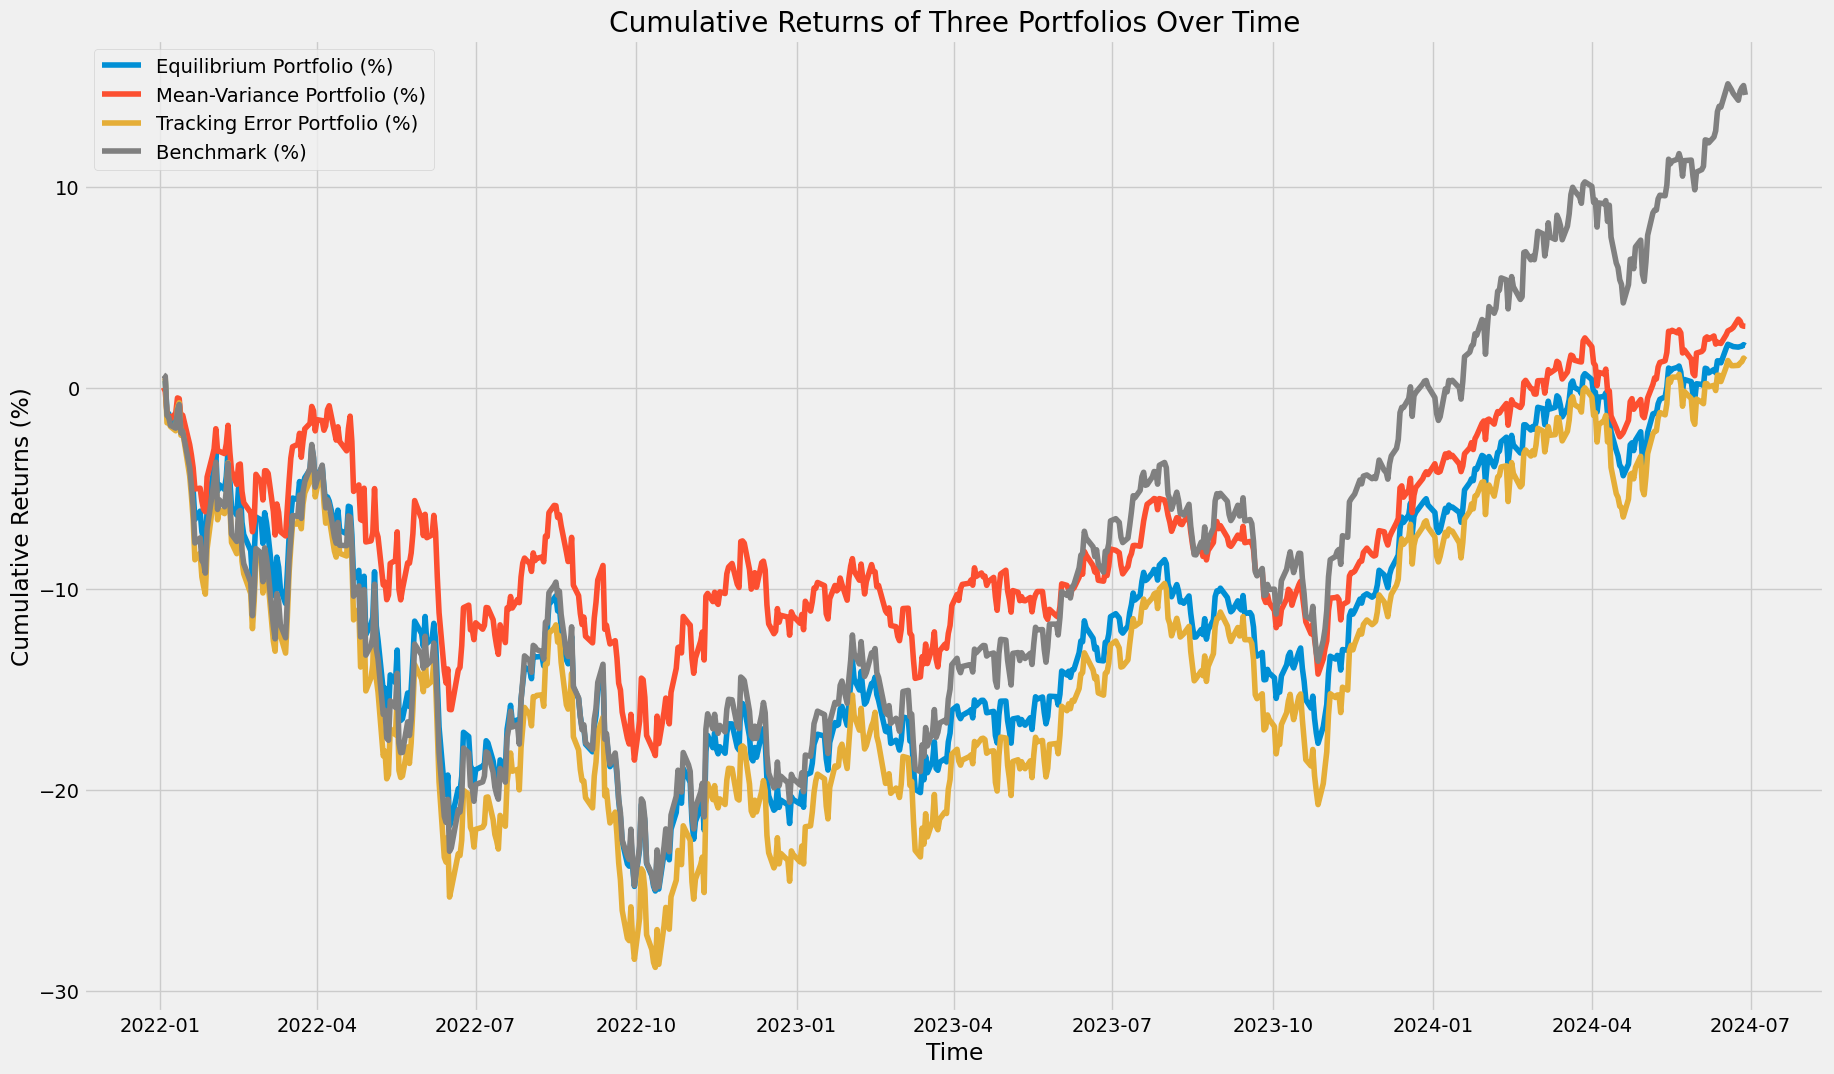

In [89]:
post_optimisation_index = common_index[common_index >= '2022-01-01']

# filter for index
log_returns_live_performance = log_returns.loc[post_optimisation_index]
benchmark_spx_500_live_performance= benchmark_spx_500.loc[post_optimisation_index]

# equilibrium_portfolio 
equilibrium_portfolio_daily_returns = log_returns_live_performance.dot(equilibrium_weights.values)
equilibrium_portfolio_cumulative_returns = ((1 + equilibrium_portfolio_daily_returns).cumprod() - 1) * 100

# constrained mean-variance
constrained_portfolio_daily_returns = log_returns_live_performance.dot(constrained_weights_vector.values)
constrained_portfolio_cumulative_returns = ((1 + constrained_portfolio_daily_returns).cumprod() - 1 )* 100

# neutral tracking error weights
tracking_error_portfolio_daily_returns = log_returns_live_performance.dot(tracking_error_weights_netural.values)
tracking_error_portfolio_cumulative_returns = ((1 + tracking_error_portfolio_daily_returns).cumprod() - 1) * 100

# benchmark
benchmark_spx_500_live_performance_cumulative = ((1 + benchmark_spx_500_live_performance).cumprod() - 1) * 100

# Plot the cumulative returns for all portfolios
plt.figure(figsize=(20, 12))
plt.plot(equilibrium_portfolio_cumulative_returns, label='Equilibrium Portfolio (%)')
plt.plot(constrained_portfolio_cumulative_returns, label='Mean-Variance Portfolio (%)')
plt.plot(tracking_error_portfolio_cumulative_returns, label='Tracking Error Portfolio (%)')
plt.plot(benchmark_spx_500_live_performance_cumulative, label='Benchmark (%)', color='grey')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.title('Cumulative Returns of Three Portfolios Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### Figure 14 - Portfolio Statistics

NameError: name 'cumulative_returns_back_testing' is not defined

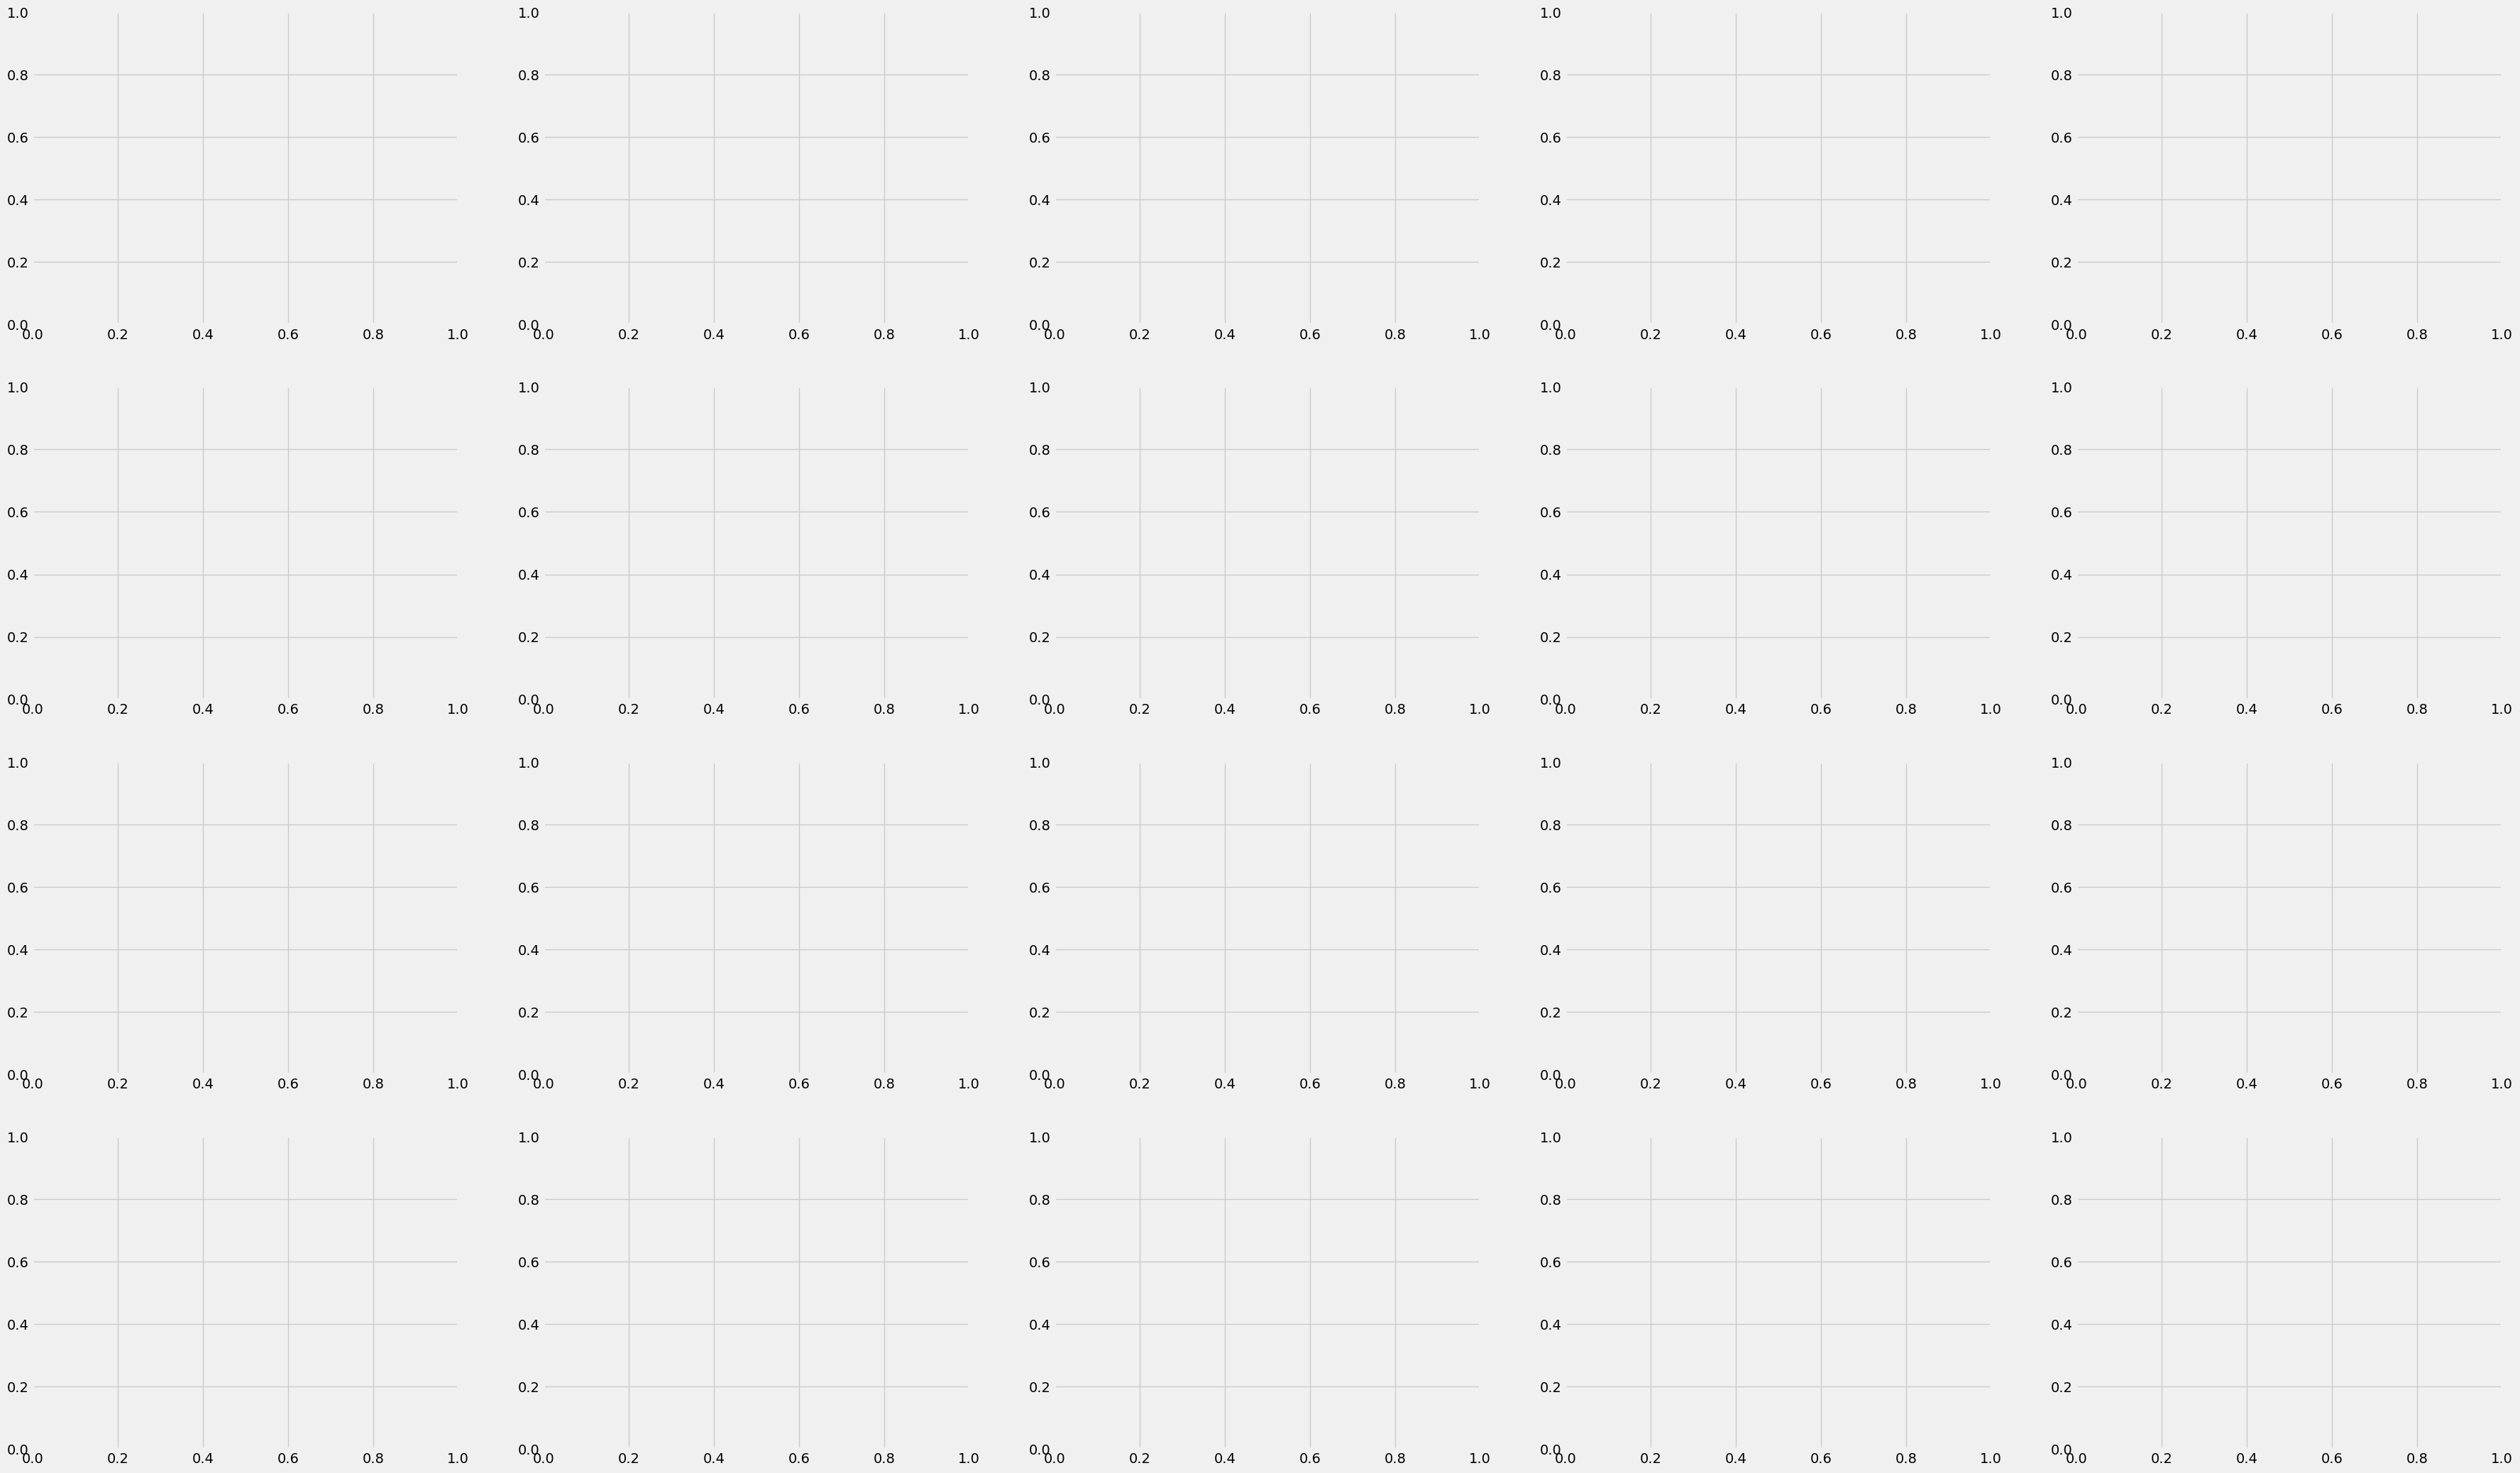

# ------------------------------------ WRITE UP ------------------------------------

#### 1.4 What is the Black-Litterman Portfolio

The initial formulation of the Black-Litterman model for Portfolio construction was described in the 1992 paper. The paper described an intuitive solution by combining the mean-variance opitimisation framework of Markowitz and the capital asset pricing model (CAPM) of Sharpe and Lintner. The issue with the CAPM model and minimum-variance portfolio decribed by Markowitz is that small tweaks in the values could lead to significant rebalancing of the portfolio. The Markowitz framework effectively takes the risk-free return as the alternative benchmark. The Black-Litterman model on the otherhand uses equilibrium risk premiums to provide a neutral reference point for expected returns, generating a market-capitalisation-weighted-portfolio and then incorporating subjective views that tilts in the direction of assets favored by the investor to enable the generation of alpha. The Black-Litterman models assumes does not assume the model is always at CAPM equilibrium, but any shift away from this equilibrium will experience pressure from the market to revert. Furthermore, the model allows the investor to have as many, or as few, views as they wish on either an absolute or relative basis. 

We will undertake the following steps in the next few sections to construct our portfolio according to the Black-Litterman framework. Firstly, we need to assign our portfolio weights based upon the market capitalisation of our benchmark portfolio. As previously outlined we will assign 92% of our portfolio to the S&P 500 sectors that we have proxied via iShares ETFs and will according allocate based on their weight in the S&P 500 in 2022. The remaining 8% of the portfolio will be equally split across our three exogenous factors, four Fama-French factors and custom momentum factor. Based on these weights we will derive the implied market returns for each of our factors. Due to this method of deriving the market implied returns the frame work does not recommend deviating from the market returns until you formulate views about the factor that cause them to deviate on either an absolute or relative basis from the implied returns. Once we have formulated our views on the market then we will combine our market implied returns and views via Bayes Theorem to construct a posterior returns distribution. 

We will then use our posterior returns distribution to calculate our views adjusted optimal weights for our portfolio. Finally, once we have completed this optimisation we will compare how our new portfolio performs vs the benchmark S&P from 2022 to 2024. 

Fig. 6 Adjusted Weights from S&P 500 per GICs Sector (2022) 

| Sector                 | Weights   |
|:-----------------------|:----------|
| Energy                 | 3.40%     |
| Materials              | 2.39%     |
| Industrials            | 7.36%     |
| Consumer Discretionary | 10.86%    |
| Consumer Staples       | 5.70%     |
| Health Care            | 12.24%    |
| Financials             | 10.58%    |
| Information Technology | 25.85%    |
| Communication Services | 8.83%     |
| Utilities              | 2.39%     |
| Real Estate            | 2.39%     |

While the Markowitz mean-variance optimisation is designed to use discrete returns, the Black-Litterman model is based on log return which we will use here. 

$$

R_{i} = log(1 + \frac{P_{i+1}}{P_i})

$$

#### 1.5 Prior Returns Distribution and Reverse Optimisation

We consider the market to be composed of $N$ securities or assets. We consider that the returns of these assets are normally distributed with the following parameters: 

$$
X \sim N(\mu, \Sigma)
$$

The Black-Litterman acknoledges the difficulty in accurately estimating the correct value for $\mu$, and chooses instead to model it as a random variable that is normally distrubute with the following parameters:

$$
\mu \sim N(\pi, \tau \Sigma)
$$

The value for $\pi$ represent the best guess for $\mu$ and the value $\tau \Sigma$ is the uncertainty of this estimation. We assume that our model has no estimation error and thereby set $\tau$ equal to zero and we can therefore conclude that the return on our market assets follows:

$$
X \sim N(\pi, \Sigma)
$$

Under normal market conditions we assume that investors maximise a mean-variance trade-off to produce the following relationship:

$$
\omega = \{ arg \max_{\omega} \omega' \pi - \lambda\omega' \Sigma\omega \}
$$

In normal optimisation under a Markowitz optimisation framework we would try to construct an accurate distribution of the returns and then use that to construct an optimal portfolio allocation for each of our assets. We are instead going to undertake the process in reverse. The Black-Litterman model is underpinned by assuming that the market weights for our $N$ assets represents an optimal allocation, and therefore we should solve our returns estimation problem by deriving the implied returns of these market allocations. We will initially solve the formula without constraints because we can arrive at a closed-form solution. Subsequently we will introduce additional constraints that would be reasonable for the average investor to encounter which will be solved by quadratic programming and provide more robust portfolio allocations:

$$
arg \max_{\omega} \omega' \pi - \lambda\omega' \Sigma\omega
$$

- $\omega$: a vector of our sector weights
- $\pi$: a vector of our implied returns
- $\lambda$: a scalar factor for risk-aversion
- $\Sigma$: covariance matrix for our returns

We take the derivative with respect to $\omega$ and then set our equation equal to $0$:

$$
\pi - 2 \lambda \Sigma w = 0
$$

We re-arrange our equation for $\pi$ to give us an equation for our implied equilibrium returns and a formula for optimal weights.

$$
\pi^{*} = 2 \lambda \Sigma w
$$

$$
\omega^{*} = \frac{1}{2 \lambda} \Sigma^{-1} \pi
$$


We can now calculate the implied market returns from our model based upon the market weights provided by the corresponding benchmark.

Fig. 7 Implied Equilibrium Returns vs Expected Return

|                        | Implied Return   | Average Return   | Avg. - Impl. Return   |
|:-----------------------|:-----------------|:-----------------|:----------------------|
| Energy                 | 6.77%            | -1.14%           | 7.91%                 |
| Materials              | 6.02%            | 8.51%            | -2.49%                |
| Industrials            | 5.89%            | 13.76%           | -7.86%                |
| Consumer Discretionary | 5.18%            | 15.94%           | -10.76%               |
| Consumer Staples       | 4.45%            | 11.28%           | -6.83%                |
| Health Care            | 4.72%            | 14.92%           | -10.20%               |
| Financials             | 6.05%            | 13.39%           | -7.34%                |
| Information Technology | 6.31%            | 19.77%           | -13.46%               |
| Communication Services | 4.90%            | 4.67%            | 0.24%                 |
| Utilities              | 3.57%            | 7.59%            | -4.02%                |
| Real Estate            | 4.88%            | 7.97%            | -3.09%                |
| Volatility (Exo)       | -29.10%          | -8.52%           | -20.58%               |
| Commodities (Exo)      | 1.58%            | -3.57%           | 5.16%                 |
| Bonds (Exo)            | -0.05%           | 0.33%            | -0.38%                |
| Factor SMB             | 0.74%            | -0.88%           | 1.62%                 |
| Factor HML             | 0.42%            | -2.71%           | 3.13%                 |
| Factor RMW             | -0.32%           | 1.79%            | -2.11%                |
| Factor CMA             | -0.35%           | -0.08%           | -0.27%                |
| Factor MOM             | -0.51%           | 1.40%            | -1.91%                |

Now that we have calculated the implied return we can arrange it alongside the average return derived from the data to see the difference. The difference is fairly stark for all our sector factors. The average return is significantly higher for the majority of our sector factors, and in particular our higher growth and cyclical sectors have almost double-digit return difference from our implied return. If we used the average returns to optimise our portfolio we would likely either generate highly levered portfolio and concentrate the portfolio in the cyclical sectors. Our exogenous and investable Fama-French factors are more difficult to discuss as we have arbitragely assigned them market weights and will provide more interesting talking points after portfolio optimisation. 

#### 1.6 Formulating Views

Naturally if we plug these implied returns back into our formula for the optimal weights we will arrive back at the market weights we initially used to derive the returns. The Black-Litterman model only suggests a deviation from the market returns once we have formulated views on assets. We need to specify our forward looking views on the market, which may or may not, clash with the reference market distribution. 

Views can either be expressed in absolute or relative terms. We will define the following views:

- View 1: Energy will generate an absolute return of 6.50%
- View 2: Information Technology will outperform Financials by 10bps. 
- View 3: The subset defensive sectors (Consumer Staples & Healthcare) will outperform the subset cyclical sectors (Consumer Discretionary & Materials) by 50bps. 

Despite the fact that we have an absolute view and a relative view, this does not necessarily suggest that we should positively allocate to the asset that we expect to either return positively or outperform the other asset. We need to compare our prediction against the implied return from the existing market weights and determine whether our view is producing either a positive or negative deviation from the implied market return, and only in the event of a positive deviation would we then increase our potential allocation. In the case of our first view we have an implied excess return for Energy at 6.77%, and therefore an excess return of 6.50% would represent a decrease of 27bps. We should expect to see a reduction in the market allocation to this sector. 

Similarly although we are predicting an outperformance by Information Technology over Financials we need to evaluate what the existing out-or-underperformance is between the two sectors. Once again we can see that the Information Technology sector currently outperforms Financials by 26bps. The prediction of 10bps would represent a decrease in the current overperformance and we could see the allocation to Information Technology reducing or Financials increasing. 

The calculation is more complicated when we evaluate multiple sectors against each other because of the interlinking allocation dynamics. We will need to form two mini portfolios with each sector given proportional weighting to it's market weights and then compare the performance of two portfolios to determine whether our relative prediction will generate a positive or negative bias towards the existing allocation. 

Fig. 8 Comparing Subset Sector Implied Excess Return

|                      | Market Weight   | Relative Subset Weight  | Weighted Return     |
|:---------------------|:---------------:|:-----------------------:|:-------------------:|
| Consumer Staples     | 5.70%           | 31.77%                  | 1.41%               |
| Healthcare           | 12.24%          | 68.23%                  | 3.22%               |
|                      |                 | **Total**               | **4.63%**           |

|                        | Market Weight   | Relative Subset Weight  | Weighted Return     |
|:-----------------------|:---------------:|:-----------------------:|:-------------------:|
| Consumer Discretionary | 10.86%          | 81.96%                  | 4.25%               |
| Materials              | 2.39%           | 18.04%                  | 1.09%               |
|                        |                 | **Total**               | **5.33%**           |

As we can see the current subset defensive sectors are underperforming the cylical sectors by 70bps, so we are expecting a change of 120bps on a relative basis. We should expect to see a noticeable re-allocation in our new portfolio allocations compared to the existing market portfolio towards our highlighted defensive sectors. 


Now that we have formulated our views on the market and what we expect to see from our portfolio re-allocations, we can move onto the mathematical formulation and implementation of our views into our model. 

#### 1.7 Views Matrices and Posterior Returns Distribution

$Q$ corresponds to our views vector. We have 3 views so we will generate a $k \times 1$ vector where k is the number of views. Each view contains a degree of uncertainty about our confidence in the view and this is represented by $ \epsilon $. This term $\epsilon$ is a random, unknown, independent, normally distributed error term with a distribution as follows:

$$
\epsilon \sim \mathcal{N}(0, \Omega)
$$

The error term itself does not enter our Black Litterman model but the difference between the error term and the expected value of $0$ will enter the model. The variance represents the uncertainty; larger the variance, the greater the uncertainty. 

The expressed views in our $Q$ vector are then mapped to the corresponding asset by the matrix $P$. Each expressed view generates a $1 \times N$ row vector and ultimately gives us a $K \times N$ matrix. The difference between an absolute view and a relative view in our matrix is defined by the row total for each option. Relative views will sum to 0 on each row, while Absolute views will not. 

Our first view was an absolute view on the Energy sector to return 6.50%. As a result the row vector will be defined with a 1 on the first asset and zeroes on all the other assets:

$$
P_1 = \begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
$$


The second view is a relative on two assets. We expect Information Technology, the 8th asset, to outperform Financials, the 7th assset. Given that this is a relative view on two assets, the nominally outpeforming asset will recieve a positive weighting while the underperforming asset will recieve a negative rating, with the restriction that the row must sum to 0. We will apply +1 and -1 to the two assets respectively:

$$
P_2 \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0 & -1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
$$

In the event that we are comparing muliple assets for a relative view then the situation is slightly more complicated. The same restriction on relative views that the row must sum up to 0 still applies, but we now need to assign values to four assets rather than just two. Satchell and Scowcroft demonstrate the use of an equal weighting scheme, whiile Idzorek uses a market capitalisation approach. Following Satchell and Scowcroft approach leads to the simple solution of applying a positive 1/N to outperforming assets while applying negative 1/N value to underperforming. 

$$
P_3 = \begin{bmatrix}
    0 & -0.5 & 0 & -0.5 & 0.5 & 0.5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
$$

This formulation is straight forward to implement but it ignores the portfolio weights and can lead to more extremem rebalancing on smaller weights sectors. Idzorek proposes that we introduce the relative subset weight for our sectors instead to mitigate this excessive re-allocation without requiring additional calculations.

$$
P = \begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & -1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & -0.1804 & 0 & -0.8196 & 0.3177 & 0.6823 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
$$

#### TODO: WRITE UP
- Derive the Meucci Framework
- Bayes Theorem

We will follow the framework set out by Meucci (2010) to incorporate the views matrices into our model. The Black-Litterman model considers views on expectations. Therefore we can see that our matrix $P$ would affect our variable $\mu$:

$$
P \mu \sim N(v, \Omega)
$$

where the parameters $v$ and $\Omega$ quantify our views and the uncertainity. We can write this in terms of equality of distribution i.e. two variables that are distributed identically:

$$
v \overset{d}{=} P\mu + Z
$$

where $Z \sim N(0, \Omega) $. We can therefore model $v$ as a random variable $V$ whose distribution, conditional on the realisation of $\mu$:

$$
V \mid \mu \sim N(P \mu, \Omega)
$$

The conditional pdf of this variable is: 

$$
f_{V \mid \mu}(v) \equiv \frac{ {\lvert \Omega \rvert}  ^{-\frac{1}{2}}}{(2\pi)^{\frac{K}{2}}} \exp^{\left(-\frac{1}{2} (v - P \mu)' \Omega^{-1} (v - P \mu)\right)}
$$

To determine the posterior of $\mu$


$$
f_{\mu \mid V}(\mu) = \frac{f_{\mu, V}(\mu, v)}{f_{V}(v)} = \frac{f_{V \mid \mu}(v) f_{\mu}(\mu)}{\int f_{V \mid \mu}(v) f_{\mu}(\mu) \, d\mu}
$$

#### 1.8 Unconstrained Optimisation for Black-Litterman Portfolio Weights

Now that we have the posterior returns for our sectors we can now obtain the optimal weights for this new distribution. We simple substitute our implied equilibrium returns for our views adjusted returns from and our new optimisation problem follows:

$$
arg \max_{\omega} \omega'\mu_{BL} - \lambda\omega'\Sigma\omega
$$


As we saw earlier in an unconstrained problem this gives us the neat solution:

$$
w^{*} = \frac{1}{2 \lambda} \Sigma^{-1} \mu_{BL}
$$

We can now compare across all our two return distributions and subsequent changes in market allocation. 

Fig. 9 - Pre-and-Post Optimisation Portfolio Weights

|                        | Adjusted Return   | Implied Return   | Adj. - Impl. Return   | Adjusted Weights   | Equilibrium Weights   | Adj. - Eq. Weights   |
|:-----------------------|:------------------|:-----------------|:----------------------|:-------------------|:----------------------|:---------------------|
| Energy                 | 6.35%             | 6.77%            | -0.42%                | 4.19%              | 3.40%                 | 0.78%                |
| Materials              | 5.60%             | 6.02%            | -0.42%                | -3.89%             | 2.39%                 | -6.28%               |
| Industrials            | 5.58%             | 5.89%            | -0.31%                | 7.30%              | 7.36%                 | -0.06%               |
| Consumer Discretionary | 4.73%             | 5.18%            | -0.45%                | -17.67%            | 10.86%                | -28.53%              |
| Consumer Staples       | 4.38%             | 4.45%            | -0.07%                | 16.68%             | 5.70%                 | 10.98%               |
| Health Care            | 4.96%             | 4.72%            | 0.25%                 | 35.81%             | 12.24%                | 23.57%               |
| Financials             | 5.77%             | 6.05%            | -0.28%                | 12.31%             | 10.58%                | 1.73%                |
| Information Technology | 5.96%             | 6.31%            | -0.34%                | 23.82%             | 25.85%                | -2.03%               |
| Communication Services | 4.72%             | 4.90%            | -0.19%                | 8.76%              | 8.83%                 | -0.07%               |
| Utilities              | 3.66%             | 3.57%            | 0.09%                 | 2.37%              | 2.39%                 | -0.02%               |
| Real Estate            | 4.76%             | 4.88%            | -0.12%                | 2.37%              | 2.39%                 | -0.02%               |
| Volatility (Exo)       | -27.69%           | -29.10%          | 1.41%                 | 0.99%              | 1.00%                 | -0.01%               |
| Commodities (Exo)      | 1.44%             | 1.58%            | -0.15%                | 0.99%              | 1.00%                 | -0.01%               |
| Bonds (Exo)            | -0.06%            | -0.05%           | -0.01%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor SMB             | 0.58%             | 0.74%            | -0.16%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor HML             | 0.29%             | 0.42%            | -0.13%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor RMW             | -0.35%            | -0.32%           | -0.04%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor CMA             | -0.31%            | -0.35%           | 0.04%                 | 0.99%              | 1.00%                 | -0.01%               |
| Factor MOM             | -0.42%            | -0.51%           | 0.09%                 | 0.99%              | 1.00%                 | -0.01%               |

The first thing to note from our new portfolio weights is that the Black-Litterman model is very resistant to change allocations unless a view specifies the need for it to take place. Although there has been a significant re-balancing our Industrials, Communication Services, & Utilities sectors alongside our exogenous and Fama-French factors have had very little adjustments to their allocations. The most significant re-allocation has been taking quite large short positions on both of cyclical sectors Consumer Discretionary and Materials, and subsequently taking significantly increased positions in Consumer Staples and Healthcare. 

We have much more restrained moves in our Information Technology and Financials sectors as we see a slightly re-balance away from the former to latter. We see a slight increase in the Energy sector despite expecting a lower return compared to the market potentially because it's adjusted return still provides the best return compared to the other sectors. 

Fig. 10 - Portfolio Allocations by Risk Aversion - Kelly vs Market vs Trustee

|                        | Equilibrium Weights   | Kelly Weights   | Market Weights   | Trustee Weights   |
|:-----------------------|:----------------------|:----------------|:-----------------|:------------------|
| Energy                 | 3.40%                 | 97.83%          | 4.19%            | -9.07%            |
| Materials              | 2.39%                 | -21.66%         | -3.89%           | -1.37%            |
| Industrials            | 7.36%                 | 0.16%           | 7.30%            | 8.31%             |
| Consumer Discretionary | 10.86%                | -98.40%         | -17.67%          | -6.24%            |
| Consumer Staples       | 5.70%                 | 38.36%          | 16.68%           | 13.61%            |
| Health Care            | 12.24%                | 82.39%          | 35.81%           | 29.22%            |
| Financials             | 10.58%                | -24.12%         | 12.31%           | 17.47%            |
| Information Technology | 25.85%                | 24.94%          | 23.82%           | 23.67%            |
| Communication Services | 8.83%                 | 0.20%           | 8.76%            | 9.97%             |
| Utilities              | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Real Estate            | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Volatility (Exo)       | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Commodities (Exo)      | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Bonds (Exo)            | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor SMB             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor HML             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor RMW             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor CMA             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor MOM             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |

#### TODO: Write up

#### 1.9 Constrained Optimisation

Now that we have our default Black-Litterman model defined and initailised we can move onto producing a more robust solution to our portfolio construction. Currently we are performing unconstrained optimisation but in reality investors can face a number of constraints. Currently in our unconstrained portfolio we are taking significant short position in both Consumer Discretionary & Materials which we want to eliminate to produce a long only portfolio. In addition to the no short position constraint we will also add a no leverage constraint. 

Our maximisation problem is formulated slightly differently now:

$$
arg \max_{\omega} \omega'\pi - \lambda\omega'\Sigma\omega
$$

s.t.

$$
w_{i} \geq 0
$$

$$
\sum_{i=1}^{n} w_{i} = 1

$$

- $\omega$: a vector of our sector weights
- $\pi$: a vector of our equilibrium returns
- $\lambda$: a scalar factor for risk-aversion
- $\Sigma$: covariance matrix for our returns
- $\textbf{1}$: This is a vector of 1

When we express a constraint to quadprog() we need to express it in the following form:

$$
\textbf{C}' \textbf{w} \geq \textbf{b}
$$

- $\textbf{C}$: is the matrix that represents the coefficients of the weights $w_{i}$
- $\textbf{b}$: is a matrix representing the right hand side of our inequality. 

We need to re-formulate our two constraints into similar formats so that we know how to define our two matrix inputs into our model. We can begin with our no-short selling constraint and convert into matrix form. For a portfolio of $n$ assets, the no-short selling constraint can be written as the following set of inequalities: 

$$
w_1 \geq 0, \quad w_2 \geq 0, \quad \dots, \quad w_n \geq 0
$$

We can therefore represent this in matrix form as: 

$$
\begin{bmatrix}
1 & 0 & \dots & 0 \\
0 & 1 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 1
\end{bmatrix}
\begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}
\geq
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
$$

This means that if we want to represent the constraint in the same format as the quadprog() is expecting we get the following values:

- $\textbf{C} = \textbf{I}$, where $I$ is an identity matrix of size $n \times n$
- $\textbf{b} = \textbf{0}$, a vector of length $n$

For our no leverage constraint it is straightforward to convert our summation notion into a matrix form:

$$
\begin{bmatrix}
1 & 1 & \dots & 1
\end{bmatrix}
\begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}
=
1
$$

- $\textbf{C} = \textbf{1}$, where $1$ is an $1 \times n$ matrix and every value is 1.
- $\textbf{b} = 1$, an integer value

Now that we have successfully reformulated our constraints in a format amenable to quadprog() we have our constraint matrices:

$$
C = 
\begin{bmatrix}
\textbf{I} \\
\textbf{1}
\end{bmatrix}
$$

$$
b = 
\begin{bmatrix}
\textbf{0} \\
1
\end{bmatrix}
$$

Fig 11. Constrained Optimisation Portfolio Weights

|                        | Equilibrium Weights   | Unconstrained Adjusted Weights   | Constrained Adjusted Weights   | Difference Weights   |
|:-----------------------|:----------------------|:---------------------------------|:-------------------------------|:---------------------|
| Energy                 | 3.40%                 | 4.19%                            | 5.12%                          | 0.93%                |
| Materials              | 2.39%                 | -3.89%                           | 0.00%                          | 3.89%                |
| Industrials            | 7.36%                 | 7.30%                            | 0.08%                          | -7.22%               |
| Consumer Discretionary | 10.86%                | -17.67%                          | 0.00%                          | 17.67%               |
| Consumer Staples       | 5.70%                 | 16.68%                           | 14.63%                         | -2.05%               |
| Health Care            | 12.24%                | 35.81%                           | 36.00%                         | 0.19%                |
| Financials             | 10.58%                | 12.31%                           | 9.75%                          | -2.56%               |
| Information Technology | 25.85%                | 23.82%                           | 17.63%                         | -6.19%               |
| Communication Services | 8.83%                 | 8.76%                            | 6.76%                          | -2.00%               |
| Utilities              | 2.39%                 | 2.37%                            | 3.50%                          | 1.12%                |
| Real Estate            | 2.39%                 | 2.37%                            | 1.27%                          | -1.10%               |
| Volatility (Exo)       | 1.00%                 | 0.99%                            | 0.95%                          | -0.04%               |
| Commodities (Exo)      | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Bonds (Exo)            | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor SMB             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor HML             | 1.00%                 | 0.99%                            | 3.40%                          | 2.41%                |
| Factor RMW             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor CMA             | 1.00%                 | 0.99%                            | 0.71%                          | -0.28%               |
| Factor MOM             | 1.00%                 | 0.99%                            | 0.19%                          | -0.80%               |

The imposition of the no-short constraint immediately causes our previous short positions to be reduce to a neutral position with no exposure to those two sectors. The Consumer Staples position is reduced slightly, but the high conviction in Healthcare remains. To maintain these two overweight positions without the short positions, all other factors in the portfolio receive a reduction in their weights versus the Unconstrained Portfolio. In particular we lose exposure to half of our Fama-French factors and exogenous factors. The portfolio appears to have reduced positions in the lowest ranking adjusted returns sectors. The constraints have worked as expected but generate a larger deviation from the equilibrium weights in the process. 

#### 1.10 Tracking Error

Tracking error is defined as the difference between the portfolio return and the benchmark return over a defined period and a given frequency. 

$$
TE = \sqrt{\frac{1}{T - 1} \sum_{t=1}^{T} (R_p(t) - R_b(t))^2}
$$

$R_p(t)$: is the portfolio return at time $t$
$R_b(t)$: is the benchmark return at time $t$
$T$: is the number of time periods

Most active managers are benchmarked against a specific index, in our framework we have replicated the S&P 500 via individual sectors and are seeking to incorporate views into our market portfolio to generate alpha. However, by deviating from the market we are taking on active risk, and our views are not qualified in terms of their strength. By incorporating an optimisation with respect to Tracking Error we can build a portfolio that limits active risk unless we have significantly divergent views. 

We can use the methodology defined by Jorion (2002) for portfolio optimisation with a tracking error constraint. We will we optimising for deviations $x$ on our equilibrium weights with the goal of maximising the return on the deviations subject to a constraint $T$ on the volatility of the tracking error. 

We will define our new variables below:

- Our new portfolio weight will be the sum of the equilibrium weights and the optimal deviations: $\omega_p = \omega_{eq} + x$: 
- The variance of the tracking error: $ T = x' \Sigma x $
- The sum of the deviations must be equal to zero: $x'1 = 0$

We can now set up our optimisation as the following: 

$$
max \space x' \pi
$$

$$
s.t.
$$

$$
x'1 = 0
$$

$$
x' \Sigma x = T
$$



We will compute our optimisation for three different values (low, neutral, high) of T to see the effects on our portfolio.

Fig. 12 Tracking Error Constrained Optimisation

|                        | Adjusted Return   | Equilibrium Weights   | Tracking Error - Low Tolerance   | Tracking Error - Neutral Tolerance   | Tracking Error - High Tolerance   |
|:-----------------------|:------------------|:----------------------|:---------------------------------|:-------------------------------------|:----------------------------------|
| Energy                 | 6.35%             | 3.40%                 | 3.88%                            | 5.25%                                | 8.64%                             |
| Materials              | 5.60%             | 2.39%                 | 2.72%                            | 3.63%                                | 5.95%                             |
| Industrials            | 5.58%             | 7.36%                 | 7.63%                            | 8.36%                                | 10.27%                            |
| Consumer Discretionary | 4.73%             | 10.86%                | 11.03%                           | 11.47%                               | 12.69%                            |
| Consumer Staples       | 4.38%             | 5.70%                 | 5.82%                            | 6.13%                                | 6.96%                             |
| Health Care            | 4.96%             | 12.24%                | 12.33%                           | 12.53%                               | 13.15%                            |
| Financials             | 5.77%             | 10.58%                | 10.89%                           | 11.75%                               | 13.93%                            |
| Information Technology | 5.96%             | 25.85%                | 26.03%                           | 26.45%                               | 27.68%                            |
| Communication Services | 4.72%             | 8.83%                 | 9.02%                            | 9.54%                                | 10.89%                            |
| Utilities              | 3.66%             | 2.39%                 | 2.56%                            | 3.02%                                | 4.19%                             |
| Real Estate            | 4.76%             | 2.39%                 | 2.67%                            | 3.45%                                | 5.40%                             |
| Volatility (Exo)       | -27.69%           | 1.00%                 | 0.04%                            | -2.03%                               | -8.92%                            |
| Commodities (Exo)      | 1.44%             | 1.00%                 | 0.93%                            | 0.72%                                | 0.27%                             |
| Bonds (Exo)            | -0.06%            | 1.00%                 | 0.74%                            | -0.07%                               | -1.92%                            |
| Factor SMB             | 0.58%             | 1.00%                 | 0.83%                            | 0.31%                                | -0.86%                            |
| Factor HML             | 0.29%             | 1.00%                 | 0.88%                            | 0.52%                                | -0.30%                            |
| Factor RMW             | -0.35%            | 1.00%                 | 0.71%                            | -0.17%                               | -2.22%                            |
| Factor CMA             | -0.31%            | 1.00%                 | 0.73%                            | -0.09%                               | -1.99%                            |
| Factor MOM             | -0.42%            | 1.00%                 | 0.57%                            | -0.75%                               | -3.81%                            |

Unsurprisingly as we increase the tracking error tolerance the further the portfolio deviates from the equilibrium portfolio. However, the portfolio does not converge slowly towards our unconstrained mean-variance portfolio with high bets on Healthcare and Consumer Staples, it actually shifts more heavily towards a larger position in Energy. We have included the views adjusted returns to help provide clarity and we can see that because Energy sector has the highest predicted risk-adjusted return the portfolio overweights Energy because that is the most efficient way to minmise return differentials with respect to the track error constraint is to take larger positions in the higher return generating sectors. As a result even tho we expect a more conservative differential portfolio to perform well according to our views matrix, the tracking error constrained portfolio is far more reluctant to invest in these lower return assets despite our views because it would lead to a higher tracking error from the predicted returns. 

#### 1.11 Portfolio Performance 

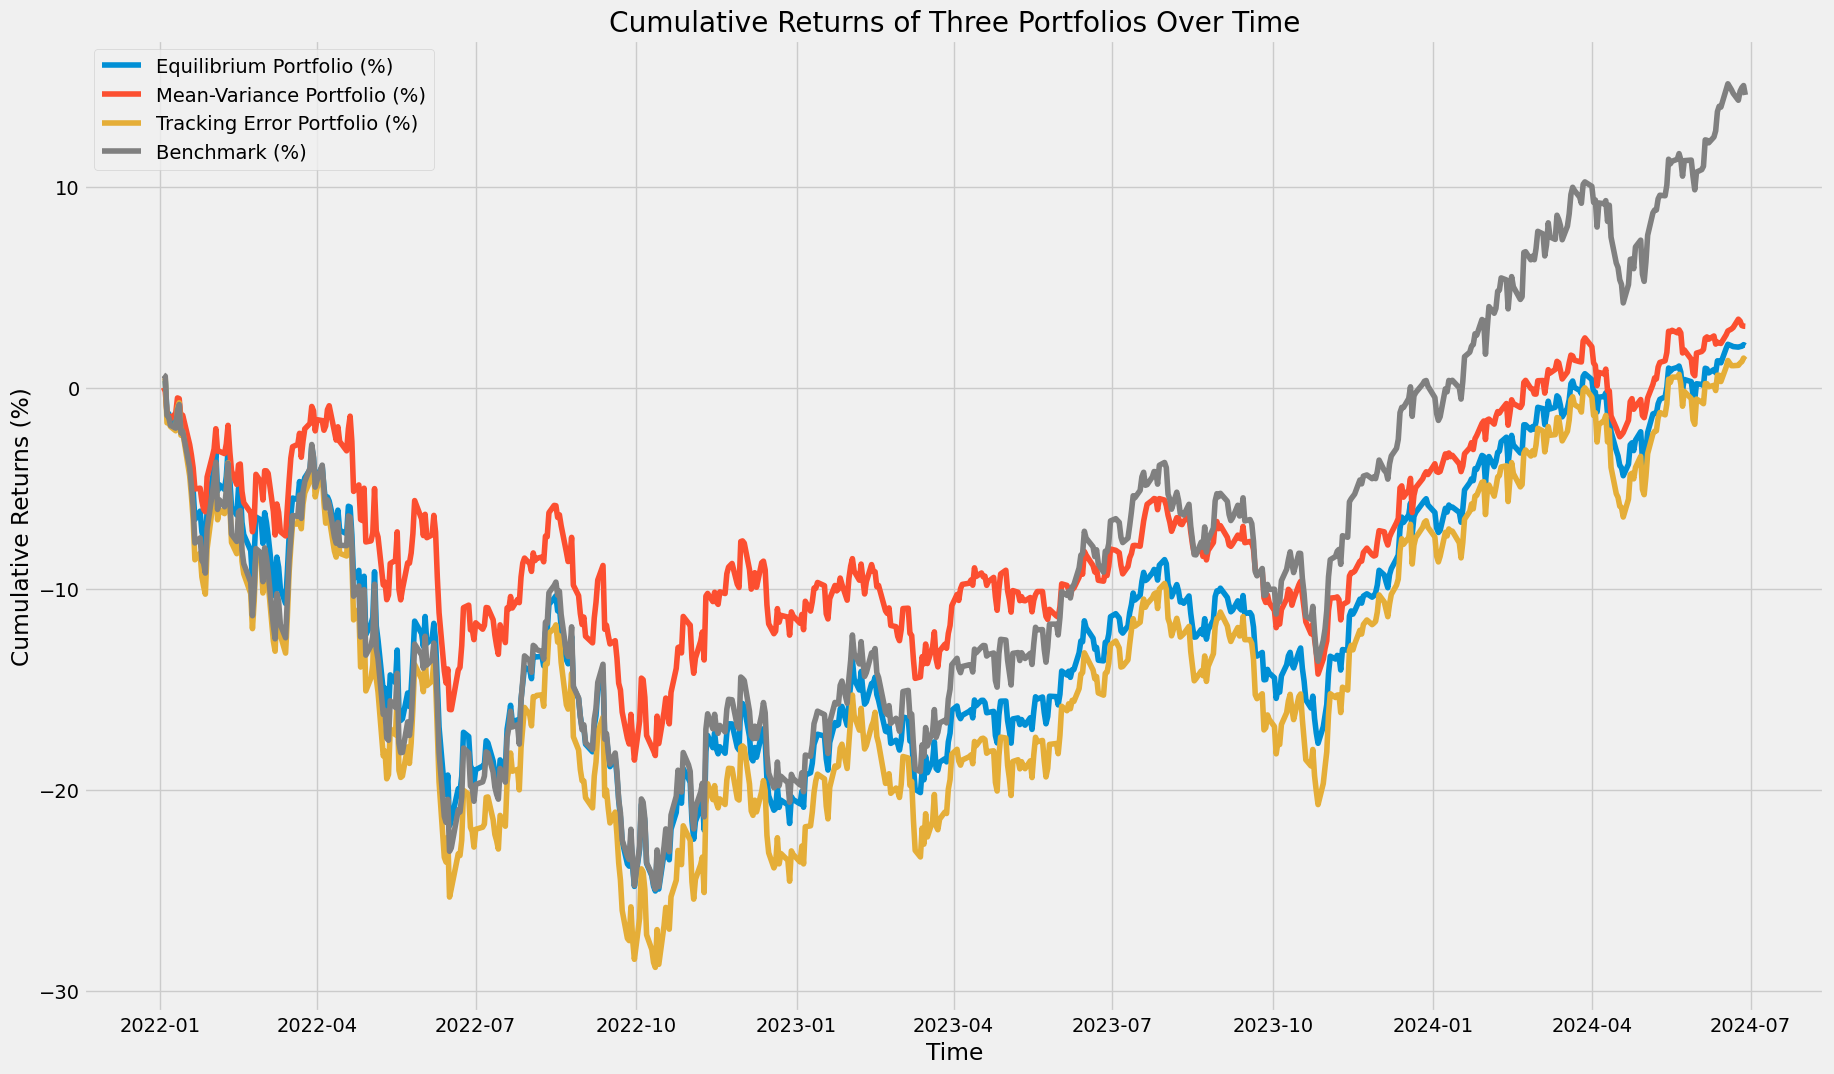

In [90]:
post_optimisation_index = common_index[common_index >= '2022-01-01']

# filter for index
log_returns_live_performance = log_returns.loc[post_optimisation_index]
benchmark_spx_500_live_performance= benchmark_spx_500.loc[post_optimisation_index]

# equilibrium_portfolio 
equilibrium_portfolio_daily_returns = log_returns_live_performance.dot(equilibrium_weights.values)
equilibrium_portfolio_cumulative_returns = ((1 + equilibrium_portfolio_daily_returns).cumprod() - 1) * 100

# constrained mean-variance
constrained_portfolio_daily_returns = log_returns_live_performance.dot(constrained_weights_vector.values)
constrained_portfolio_cumulative_returns = ((1 + constrained_portfolio_daily_returns).cumprod() - 1 )* 100

# neutral tracking error weights
tracking_error_portfolio_daily_returns = log_returns_live_performance.dot(tracking_error_weights_netural.values)
tracking_error_portfolio_cumulative_returns = ((1 + tracking_error_portfolio_daily_returns).cumprod() - 1) * 100

# benchmark
benchmark_spx_500_live_performance_cumulative = ((1 + benchmark_spx_500_live_performance).cumprod() - 1) * 100

# Plot the cumulative returns for all portfolios
plt.figure(figsize=(20, 12))
plt.plot(equilibrium_portfolio_cumulative_returns, label='Equilibrium Portfolio (%)')
plt.plot(constrained_portfolio_cumulative_returns, label='Mean-Variance Portfolio (%)')
plt.plot(tracking_error_portfolio_cumulative_returns, label='Tracking Error Portfolio (%)')
plt.plot(benchmark_spx_500_live_performance_cumulative, label='Benchmark (%)', color='grey')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.title('Cumulative Returns of Three Portfolios Over Time')
plt.legend()
plt.grid(True)
plt.show()

We can now plot the cumulative returns for our two optimised portfolios (Mean-Variance & Tracking Error), against both our Equilibrium (2022 weights) portfolio and the real-world returns of the S&P500 as our benchmarks. We can see that with respect to our benchmark portfolios that they do not meaningfully diverge until Q2 of 2023 when the S&P begins to recover from market downturn from the past year and cyclical sectors like Information Technology begin to produce strong returns. Naturally, our Tracking Error portfolio tightly tracks the performance of our Equilibrium portfolio but due to the shift away from more cyclical sectors to go overweight in our defensive sector Energy we are able to meaningful generate a small amount of alpha until 2023. Our Mean-Variance diverged much more strongly from our equilibrium portfolio and was able to substantially allocate to defensive sectors and avoids the considerable drawndown that the other portfolios thoroughout 2022, and generate significant alpha over both benchmark portfolios until late 2023 when the market shifts decisively in favour of cyclical sectors particularly related to AI. The results suggest that our views were well informed until 2023 when a portfolio re-balance should have taken place with some revisions to our views to incorporate new market trends. 


#### 1.12 Conclusion

This reports has demonstrated how useful the Black-Litterman model can be towards portfolio construction. The model provides an intuitive framework for building a robust and appropriately diversified portfolio that can easily incorporate the investor's views about market conditions. The framework for the model can be implemented in the basic framework devised by Black and Litterman and offers natural options to extend the model and improve the robustness of the results. 

The model defined in this paper did encounter some limitations that could be improved in susequent iterations. The Tracking Error optimisation should require further constraints to improve robustness. Currently, the model only support very tight assignments to the total Tracking Error variance before it diverges in unrealistic portfolio allocations. Both of the existing models strongly allocate away from our exogenous and Fama-French factors despite both our VIX and MOM factors providing interesting diversification benefits in times of market stress since in the initital analysis of the portfolio. Currently, the model has no way to favour different allocations in different market regimes and so in the absence of strongly supportive views it is unable to justify allocating to sectors that provide returns on a less consistent basis. Finally, we were unable to implement extensions that could qualify the strength of the market views. The current model treats each view as equally strong, and the ability to provide a range of market outcomes with different probabilities would improve the robustness of the portfolio results. 

#### User Defined Methods

user

calculate_covariance_matrix

calculate_implied_equilibrium_returns

calculate_views_adjusted_returns

calculate_unconstrained_mv_optimisation

calculate_constrained_mv_optimisation

calculate_tracking_error_optimisation

python

minimize 


#### Bibliography

Black, F. and Litterman, R. 1990. Asset Allocation: Combining Investors Views with Market Equilibrium. Goldman Sachs Fixed Income Research working paper

Black, F. and Litterman, R. 1991. Global Asset Allocation with Equities, Bonds, and Currencies. Goldman Sachs Fixed Income Research working paper

Black, F. and Litterman, R. 1992. Global Portfolio Optimization.Financial Analysts Journal, 28-43.

Idzorek, T.M. 2002. A step-by-step guide to Black-Litterman model. Incorporating user-specified confidence levels. Working Paper, 2-11.

Satchell, S. and Scowcroft, A. (2000). “A Demystification of the Black-Litterman Model: Managing Quantitative and Traditional Construction.” Journal of Asset Management, September, 138-150.

Markowitz, H., 1952. Portfolio Selection. The Journal of Finance, 7(1): 77-91.

Fama and French Data Library - http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

Fama, Eugene F. and French, Kenneth R., Production of U.S. Rm-Rf, SMB, and HML in the Fama-French Data Library (December 18, 2023). Chicago Booth Research Paper No. 23-22, Fama-Miller Working Paper

Meucci, A. 2010. The Black-Litterman Approach: Original Model and Extensions

JORION
